## TL;DR

- We consider the floating escalator, a combination of 1559's "default price" and the escalator's "incremental bidding".
- We define and compare the efficiency of two user strategies:
    - _Hurrying users_ set the escalator slope to their cost for waiting one more unit of time, and balk whenever their current value is negative.
    - _Fixed duration users_ all set the length of the escalator to the same value, and set the slope to ramp as much as possible within that length.
- The two strategies give rise to different dynamics, which we interpret visually.
- While the social welfare is higher in _hurry_ than in _fixed_, this may not matter as neither were shown to be equilibrium configurations. We focus instead on _user efficiency_, the total value realised by users in the market.
- We discuss _optimality_ of fee markets and settle on a definition that seems natural for this setting. The user efficiency of both strategies is compared with this optimum, as well as a "random benchmark".

---

We've discussed EIP 1559 over the course of several notebooks. A competing proposal, dubbed "escalator", was [introduced by Dan Finlay](https://github.com/ethereum/EIPs/blob/master/EIPS/eip-2593.md), taking inspiration from a paper by [Agoric](https://agoric.com/papers/incentive-engineering-for-computational-resource-management/full-text/).

We take the current first-price auction paradigm as our benchmark. 1559 removes the auction component, attempting to quote a price for users based on supply of gas and demand for it. Users become price-takers most of the time, with their only decision being whether to transact or not.

The escalator proposal is a somewhat orthogonal direction from 1559. It retains some aspect of the first-price auction mechanism (users competing against each other) but allows users to "bump up" their bid following a linear formula. For instance, I initially bid 10 and specify that with each passing block, my bid should be increased by 5, until it reaches some maximum that I also defined. If I am included immediately, my gas price is 10. One block later, it is 15, etc.

The pattern of resubmitting transactions at a higher bid is known to most users of Ethereum. Manual resubmission of transactions is enabled by most wallets, while services such as [any.sender](https://www.anydot.dev/) allow you to programmatically emulate resubmission. The escalator _automates it in protocol_, in the sense that users do not need to manually resubmit, but set the parameters for the fee increase once and for all before sending the transaction to the pool, where its bid increases.

So on one axis we have a protocol-determined objective fee equalising supply and demand. On the other, we have control over bidding behaviour. The first is useful most of the time, in particular when [demand is stationary](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/stationary1559.ipynb). Yet the second may be desirable for these short periods where demand drastically changes and user behaviour reverts to [strategic first-price auction-style bidding.](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/strategicUser.ipynb) Could we combine the two?

In this notebook, we investigate the **floating escalator**, a proposal to do so. We'll introduce its dynamics and study some user behaviours under this paradigm.

## Setting up

See this repository's [README](../README.md), for more instructions on how to run this notebook. The first step is to import the relevant objects from our library.

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from typing import Sequence

from abm1559.utils import (
    constants,
)

from abm1559.txpool import TxPool

from abm1559.users import (
    UserFloatingEsc,
)

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
)

from abm1559.txs import (
    Transaction,
    TxFloatingEsc,
)

import pandas as pd
pd.set_option('display.max_rows', 20)
import numpy as np
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

## Floating escalator 101

Since the floating escalator relies on a combination of both 1559 and the escalator, we'll introduce each one in turn before looking at their combination.

### Basefee in 1559

EIP 1559 targets a specific block size `c`. When blocks are too full, a price known as the _basefee_ increases. More people want in? Fine, we'll raise the price. Over time, the basefee fluctuates, with higher values reached when more users want to transact.

The basefee is governed by a simple equation

```python
basefee[t+1] = basefee[t] * (1 + d * (gas_used[t] - c) / c)
```

where `gas_used[t]` is the amount of gas used by block `t`. Note that blocks can use at most `2 * c` gas, twice the target. When they do, and are full, the update rule above becomes `basefee[t+1] = basefee[t] * (1 + d)`.

The adjustment speed `d` is currently set at 12.5%, which implies that the basefee after a full block increases by 12.5% (and basefee after an empty block decreases by 12.5%) <span class="reference footnote" refid="adjustment"></span>.

### Escalator

In the escalator paradigm, a user submits:

- Their starting bid `start_bid`
- The starting block `start_block`
- How many blocks the bid is valid for, `length`
- Their maximum bid `max_bid`

Over `length` blocks, the true bid `bid[t]` at block `t` follows a linear interpolation of `start_bid` and `max_bid`, with

```python
bid[t] = start_bid + (t - start_block) / length * (max_bid - start_bid)
```

At `t = start_block`, `bid[t] = start_bid`. At `t = end_block`, `bid[t] = end_block`.

In other words, the bid escalates slower or faster, depending on how much time it is valid for and how high the maximum bid is.

For example, if I submit 10 as my initial bid, 20 as my maximum, and 5 as the number of blocks over which my bid is valid for, then, as long as my transaction hasn't been included yet, my bid will increase by 2 every block for the next 5 blocks (in other words, until my bid reaches 20).


### Floating escalator

In the escalator paradigm, users must set a large number of parameters (start bid, max bid, duration of the escalator). Meanwhile, 1559 gives us this nice gas price "oracle" that tells you the market conditions as you start transacting. Combining the two would be nice! What if our escalator could "start" with the current 1559-predicated price, the basefee, and climb the bid from there?

What exactly climbs in the floating escalator? Remember that, under 1559, users specify a gas premium (or the maximum amount that a miner can receive from including the transaction). During transitions -- for example, a spike in demand -- we've seen users become strategic and "overbid". Ideally, there would exist some sort of fixed premium that would be expected to compensate the cost for a miner to include one extra transaction. The escalator governs the dynamics of this premium.

We call this hybrid "floating": we see the basefee as a kind of tide, rising and lowering with demand. The escalator starts at or near the tide, depending on `start_premium`. Meanwhile, the gas premium offered to the miners climbs _in excess_ of the basefee. For instance, assume Alice starts her escalator at the basefee equal to 5 Gwei and increases the bid by 1 Gwei each block. She also specifies that she never wants to pay more than 15 Gwei.

<AxesSubplot:xlabel='block_height'>

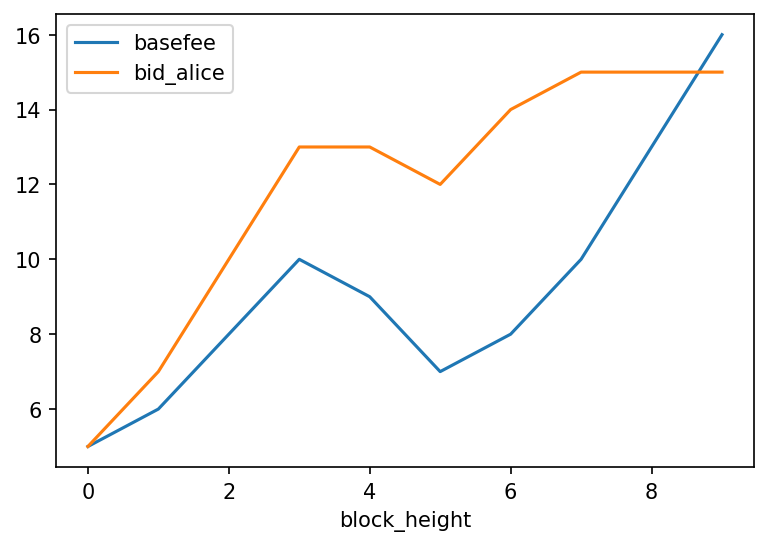

In [2]:
basefees = [5, 6, 8, 10, 9, 7, 8, 10, 13, 16]
bids_alice = [min(15, basefees[i] + i) for i in range(10)]

df = pd.DataFrame({
    "block_height": range(10),
    "basefee": basefees,
    "bid_alice": bids_alice,
})
df.plot("block_height", ["basefee", "bid_alice"])

Notice the distance between the basefee (in blue) and Alice's bids (in orange) increases over time, by 1 Gwei per block, until Alice reaches her maximum bid of 15.

At block 6, the basefee is 8 Gwei, so Alice's bid is 14 Gwei (8 Gwei from the basefee, 6 Gwei from her escalator). Then at block 7, the basefee increases to 10 Gwei. While Alice's bid ought to be 17 Gwei (10 Gwei from the basefee, 7 Gwei from her escalator), it is capped at 15 Gwei (the maximum amount Alice is willing to pay). We'll assume that after 10 blocks, Alice's transaction simply drops out.

Suppose a different user, Bob, starts at the same block as Alice, with an increase of 0.5 Gwei per block, and the same 15 Gwei limit.

<AxesSubplot:xlabel='block_height'>

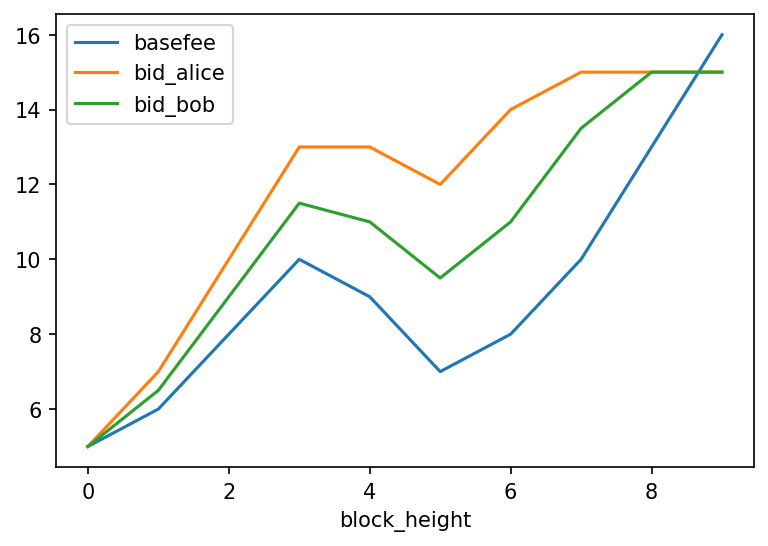

In [3]:
bids_bob = [min(15, basefees[i] + 0.5 * i) for i in range(10)]
df["bid_bob"] = bids_bob
df.plot("block_height", ["basefee", "bid_alice", "bid_bob"])

We see Bob's bids in green. Notice that they keep below Alice's bids. In a sense, Bob is more conservative than Alice is. Alice might be in a hurry to get her bid included, and doesn't mind "overpaying" (i.e. taking the risk that the increment she chose was too large). Bob, on the other hand, prefers to slowly escalate his bid. All things equal, Alice should be included before Bob is, since miners receive the difference between her bid and the basefee.

## Hurried users in the floating escalator

In our model, users have both a _value_ for the transaction, $v$, and a _cost for waiting_, $c$. Getting included immediately nets you a payoff of $v$, minus the transaction fees expended. Getting included 2 blocks later, $v - 2c$, minus the transaction fees, etc.

Since $c$ represents the time preferences of the user (a higher $c$ means it is more costly for me to wait), we could decide the escalator slope based on $c$: the higher the $c$, the higher the slope and escalator increments. This is an appropriate strategy for users who care about getting in as fast as possible given their waiting costs. For instance, users chasing an arbitrage opportunity or optimistic rollup dispute resolution transactions have high waiting costs, and thus would ramp up quickly within a short amount time.

Which brings us to the question: How long should the escalator ramp up for? Given bid increments of amount $s$, after $t$ blocks, assuming a constant basefee $b$, my bid is $b + t \times s$. Meanwhile, if my transaction is included at $t$, my payoff is $v - t \times c - (b + t \times s)$. **We never want this payoff to become negative**: since this would mean we would be worse off transacting than not! To ensure this never happens, we can figure out the number of blocks $t$ after which the previous expression becomes negative and use that as the duration of the escalator.

So how large should our increments be? We could set them to some fraction of the cost per unit, to respect the intuition that users who are in a hurry should set higher increments. To simplify for now, we'll set them to be exactly the user's cost per unit.

In our simulations, the users' bids won't start on the basefee exactly. We'll define the `start_premium` parameter as one escalator increment: if this increment is $c$, the first bid the user places is $b + c$ <span class="reference footnote" refid="escincrement">[2]</span>.

We've written a "dummy" `UserFloatingEsc` class in the library (`abm1559/users.py`) that we extend here to specify the parameters discussed above.

In [4]:
class UserHurryEsc(UserFloatingEsc):
    
    def decide_parameters(self, env):
        basefee = env["basefee"]
        slope = self.cost_per_unit
        escalator_length = int(((self.value - basefee) / self.cost_per_unit - 1) / 2)
        max_fee = basefee + (escalator_length + 1) * self.cost_per_unit
        max_block = self.wakeup_block + escalator_length
        start_premium = slope
        
        tx_params = {
            "max_fee": max_fee, # in wei
            "start_premium": start_premium, # in wei
            "start_block": self.wakeup_block,
            "max_block": max_block,
            "basefee": basefee,
        }
        return tx_params

Note that since the floating escalators have an expiry date (the max block after which they cannot be included), we create a new transaction pool which removes expired transactions. 

In [5]:
class TxPoolFloatingEsc(TxPool):
    
    def add_txs(self, txs: Sequence[Transaction], env: dict) -> None:
        invalid_txs = [tx_hash for tx_hash, tx in self.txs.items() if not tx.is_valid(env)]
        self.remove_txs(invalid_txs)
        super().add_txs(txs)

As in our previous notebooks, we'll write out the main simulation loop.

In [6]:
def simulate(demand_scenario, shares_scenario, TxPool=TxPoolFloatingEsc, rng=None):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()

    for t in range(len(demand_scenario)):
        
        # `env` is the "environment" of the simulation
        env = {
            "basefee": basefee,
            "current_block": t,
        }
        
        # We return some demand which on expectation yields demand_scenario[t] new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t], rng=rng)
        
        # Add users to the pool and check who wants to transact
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs, env)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env, user_pool=user_pool, rng=rng)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)
        
        # The block is added to the chain
        chain.add_block(block)

        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

In [7]:
users_per_round = 2500
blocks = 50

We'll only simulate `UserHurryEsc` first, setting the average number of new users spawning between two blocks at 2,500. Our blocks can only accommodate 952 of them at most, so this will create congestion.

In [8]:
rng = np.random.default_rng(42)
demand_scenario = [users_per_round for i in range(blocks)]

shares_scenario = [{
    UserHurryEsc: 1,
} for i in range(blocks)]

(df_hurry, user_pool_hurry, chain_hurry) = simulate(demand_scenario, shares_scenario, rng=rng)

Let's observe some results!

In [9]:
df_hurry

,block,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,pool_length
0,0,1.000000,2542,2355,952,1.796545,0.796545,1403
1,1,1.124900,2473,2269,952,2.052800,0.927900,2684
2,2,1.265400,2515,2302,952,2.415915,1.150515,3907
3,3,1.423448,2437,2215,952,2.854479,1.431031,5015
4,4,1.601237,2430,2143,952,3.211069,1.609831,5968
...,...,...,...,...,...,...,...,...
45,45,15.687228,2520,469,469,16.176957,0.489729,0
46,46,15.657618,2508,505,505,16.181792,0.524174,0
47,47,15.776029,2426,459,459,16.280334,0.504306,0
48,48,15.704839,2479,496,496,16.182209,0.477370,0


We recognise dynamics that should be familiar to us now. While the same average number of `users` spawn each block, and blocks are full in the first few steps, by the end of the simulation a much smaller number of users decides to actually transact (`decided_txs`). A new phenomenon is the `pool_length` being exactly zero by the end. Since transactions expire, old unincluded transactions are removed, while new transactions in the pool are all included. The basefee has reached its stationary level after which most users are priced out. This is confirmed by the following plot.

<AxesSubplot:xlabel='block'>

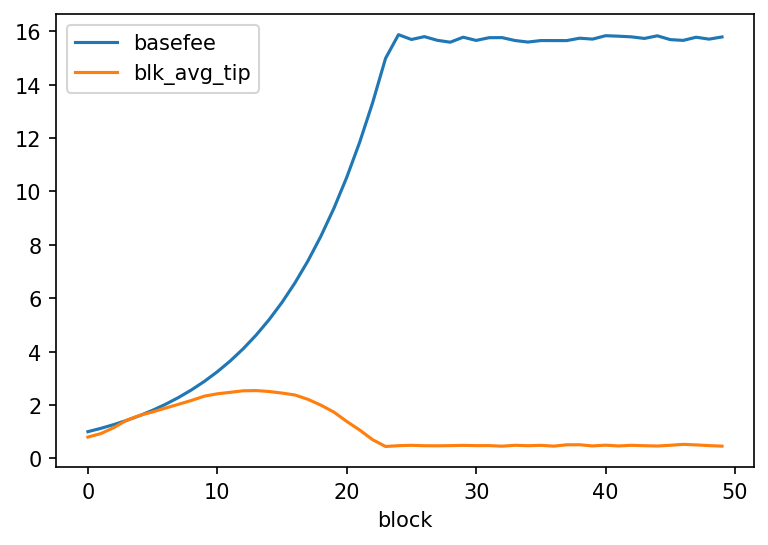

In [10]:
df_hurry.plot("block", ["basefee", "blk_avg_tip"])

Note the average tip in orange: in the first 20 blocks, when there is true competition from a shift in demand, many users want in given the low basefee amount, too many for all to be included. Those who wait in the pool see their bids escalate with increments equal to their cost per unit of waiting time. Miners of the blocks including highly escalated bids receive a much heftier tip, the difference between the user's bid and the current basefee. This comes to an end once basefee is stationary, after which priced out users do not even care to join the pool, escalating bids or not.

In [11]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_hurry_df = user_pool_hurry.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_hurry_df = chain_hurry.export()

# Join the two to associate transactions with their senders
user_txs_hurry_df = chain_hurry_df.join(user_pool_hurry_df.set_index("sender"), on="sender")

# We'll only look at the first 16 blocks
first_blocks = user_txs_hurry_df[user_txs_hurry_df.block_height <= 15].copy()
first_blocks["wakeup_block"] = first_blocks["wakeup_block"].astype("category")

Below, we are plotting the distribution of users included in each successive block. On the x-axis, we represent the value of the user $v_i$, while on the y-axis, we plot the cost per unit of time waiting $c_i$. Each point on one plot corresponds to one included transaction, with the point located at the (value, cost per unit) coordinates of the user. Additionally, we give a distinct colour to each wave of new users: users spawned before block 0 are blue, those spawned between blocks 0 and 1 are orange etc.

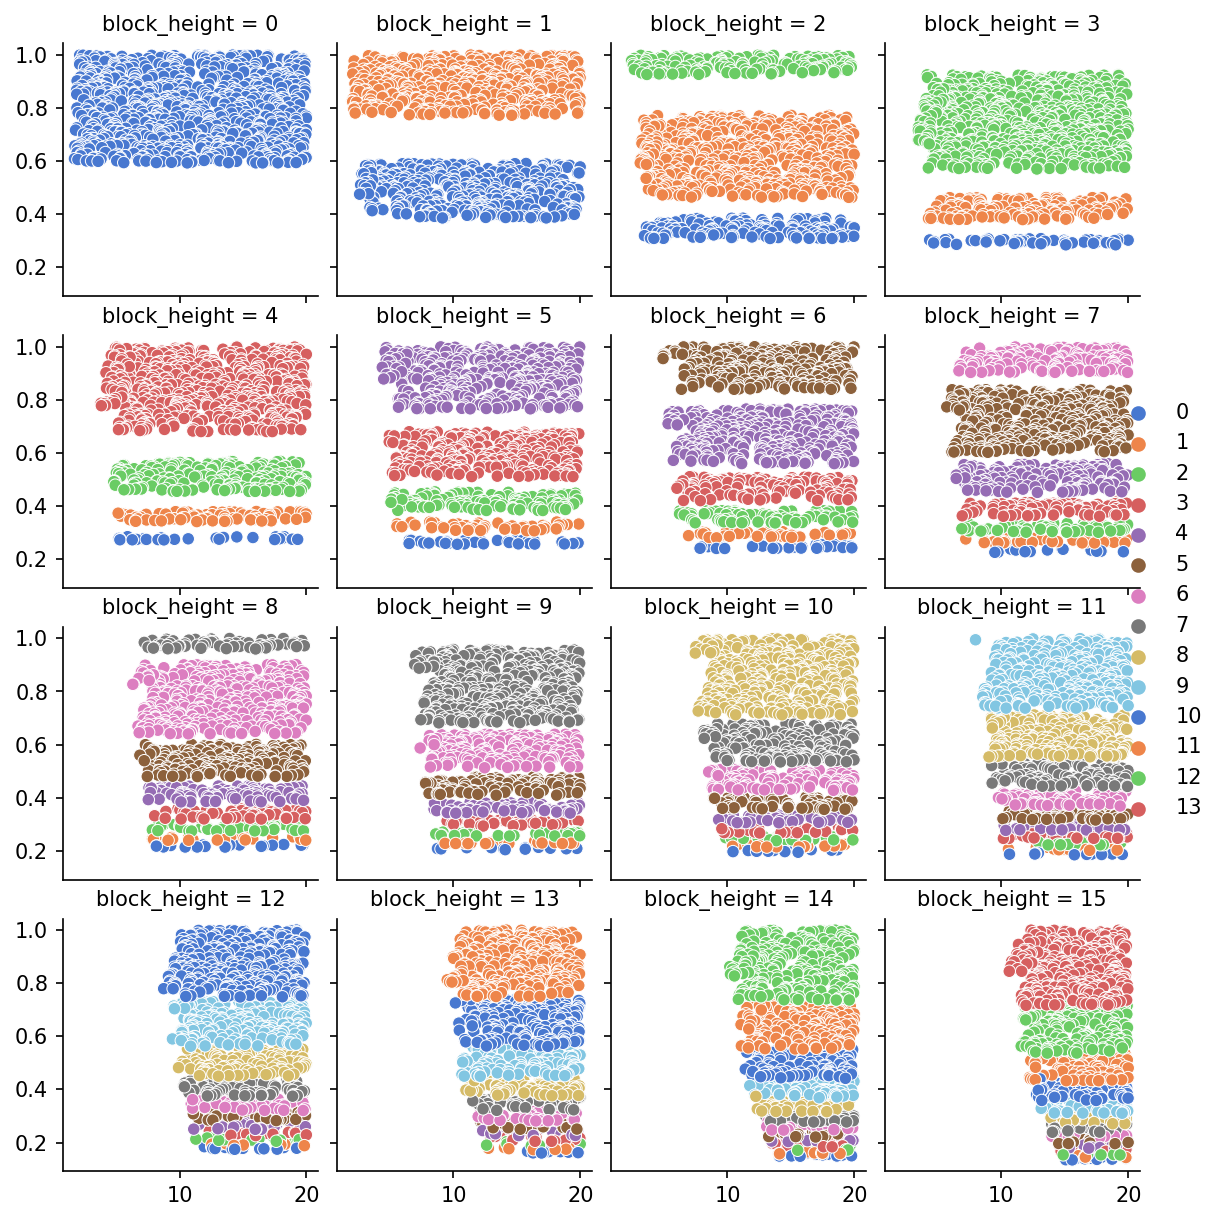

In [12]:
g = sns.FacetGrid(data=first_blocks, col="block_height", col_wrap = 4)
g.map_dataframe(sns.scatterplot, x="value", y="cost_per_unit", hue="wakeup_block", palette="muted")
g.add_legend()
g.fig.set_figwidth(8)
g.fig.set_figheight(8)

The plot is quite busy, but we can observe the following:
 
- Focusing on the first plot (`block_height = 0`), we clearly see that only users with higher time preferences (high cost per unit) are included. This is not entirely surprising since they offer a premium equal to their cost for waiting, so miners who rank users according to that premium will prefer users with higher premiums -- and thus higher time preferences.
- On the second plot (`block_height = 1`), we see that most included users are new users in orange (who appeared just before block 1), while some users from the previous wave (in blue) are included too. These late users are users spawned before block 0 with relatively low cost per unit. Yet, having waited one block already, their escalating premium is higher than some of the new users spawned just before block 1, which justifies their inclusion.
- This goes on for the following steps, further waves of users appear, with the most hurried of these users included in the block as they appear while others wait for their turn, yielding their spots to users from previous waves who have waited longer.
- Another item to notice is the progressive shift to the right of the points. Remember that while all these transactions are included, blocks are getting full, and the basefee increases! This means **low-value users are progressively getting discouraged** from sending their transactions in. By block 15, only users with value greater than 10 Gwei per gas unit are included.
- It is not only progressively shifting to the right, it is also narrowing at the base. We even see users spawned in the first wave, before block 0, included in block 15. These users have a high value for the transaction, but a really low cost for waiting: they don't mind getting in much later as long as they get in eventually. The increments of their escalators are very small, but to stay in the race long enough, they must have a much higher value than fresher users with higher cost for waiting.

### Computing social welfare

The question then is: does the extra transaction expressivity afforded by the escalator improve the efficiency of the fee market? We first need to be clear what efficiency means in this context. A common measure in algorithmic game theory is the _social welfare_: the total payoff received by all users (transaction senders **and** miners) minus the costs they incur.

In our case, we have users with personal values $v_i$ and cost for waiting $c_i$. We run the fee market for blocks over time period $T$, when blocks $B_1, \dots, B_T$ are produced. Transaction senders pay transaction fees to miners, so this cost to the senders is merely extra payoff for the miners. In other words, the transaction fees do not participate to the social welfare calculation. The basefee does however, it is burnt, irretrievable and constitutes a cost to the system of miners and senders <span class="reference footnote" refid="burnt">[3]</span>.

$$ \text{Social welfare}((b_t)_t, (w_i)_i) = \sum_{t \in T} \sum_{i \in B_t} g_i ( v_i - w_i \times c_i - b_t) $$

where $g_i$ is the gas used by sender $i$, $w_i$ is how long the user has waited and $b_t$ is the basefee at block $t$. The social welfare (SW) is determined by the realisation of $(b_t)_t$ and $(w_i)_i$, which are not exogenous to the system (while $(g_i)_i, (v_i)_i$ and $(c_i)_i$ are).

The sum above is only carried over _included_ users. Users who are not included pay nothing and receive no value either <span class="reference footnote" refid="inclusion">[4]</span>. **All things equal, SW is higher whenever users with higher costs for waiting get in quickly, or whenever users with higher values are included.**

Let's investigate by computing the social welfare in the previous simulation. `user_txs_hurry_df` holds user data of all users who were included. Since all transactions in our simulation use the same amount of gas, we do not include this parameter in the social welfare.

In [13]:
user_txs_hurry_df["total_sw"] = user_txs_hurry_df.apply(
    lambda row: row.value - (row.block_height - row.wakeup_block) * row.cost_per_unit - row.basefee,
    axis = 1
)

We store in a new column `total_sw` the welfare achieved by each included transaction. We'll now sum them all up to obtain the social welfare.

In [14]:
sw_hurry = sum(user_txs_hurry_df["total_sw"])
sw_hurry

216733.6431947058

Hmmm, cool, I guess? That number alone is not very useful -- we'd better find something to compare it with. Why not try a different user strategy?

## The fixed escalator length strategy

We've looked at a behaviour, _hurry_, where the length of a user escalator depends on the value and the cost of waiting for that user. Now, we look at the _fixed_ strategy, which assumes **the length of the escalator is fixed and the slope depends on the user value and waiting costs**.

This strategy is suitable for users who know how long they are willing to wait for but don't necessarily care for being included so quickly, for instance, buying an NFT and waiting for delivery.

Say all users set up their escalators to last $\ell = 10$ blocks. After waiting for 10 blocks, the value for inclusion to user $i$ is $\overline{v}_i = v_i - 10c_i$. We can use this value as the maximum fee they are ever willing to pay. If the basefee increases significantly in the meantime, their bid may reach the limit earlier, but at least users are guaranteed to never overpay and realise a negative payoff.

Once again, we'll want their initial bid to be the basefee plus one increment of their escalator. To determine the slope of the escalator, we simply look for the value $s_i$ such that

$$ b + s_i + \ell \times s_i = \overline{v}_i \Leftrightarrow s_i = \frac{\overline{v}_i - b}{\ell + 1} $$

This is implemented in the `UserFixedDuration` class below.

In [15]:
class UserFixedDuration(UserFloatingEsc):
    
    def decide_parameters(self, env):
        escalator_length = 10
        max_fee = self.value - escalator_length * self.cost_per_unit
        slope = (max_fee - env["basefee"]) / (escalator_length + 1)
        max_block = self.wakeup_block + escalator_length
        start_premium = slope
        
        tx_params = {
            "max_fee": max_fee, # in wei
            "start_premium": start_premium, # in wei
            "start_block": self.wakeup_block,
            "max_block": max_block,
            "basefee": env["basefee"],
        }
        return tx_params

We'll run the simulation again with these new users.

In [16]:
rng = np.random.default_rng(42)
demand_scenario = [users_per_round for i in range(blocks)]

shares_scenario = [{
    UserFixedDuration: 1,
} for i in range(blocks)]

(df_fixed, user_pool_fixed, chain_fixed) = simulate(demand_scenario, shares_scenario, rng=rng)

Checking out the results...

In [17]:
df_fixed

,block,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,pool_length
0,0,1.000000,2542,2542,952,1.968813,0.968813,1590
1,1,1.124900,2575,2575,952,2.170934,1.046034,2422
2,2,1.265400,2525,2525,952,2.474802,1.209402,3158
3,3,1.423448,2534,2534,952,2.843921,1.420473,3894
4,4,1.601237,2435,2435,952,3.252617,1.651380,4463
...,...,...,...,...,...,...,...,...
45,45,11.223676,2492,2492,540,11.473954,0.250277,1978
46,46,11.411673,2473,2473,468,11.679688,0.268015,2005
47,47,11.387138,2532,2532,495,11.641212,0.254074,2042
48,48,11.443362,2470,2470,457,11.703143,0.259782,2013


What stands out immediately is that many more users decide to join the pool, even in the last blocks, after the basefee has mostly priced everyone out. Previously, we always observed `decided_txs == included_txs` by blocks 45-49, with priced out users not deciding to join the pool in the first place. 

But with the fixed duration strategy implemented, we never allow a user to ever realise a negative payoff, so there is no reason for a user not to join, and so we have `users == decided_txs`. Meanwhile, the transaction pool checks for transaction validity, and removes all invalid transactions. We can define validity in two ways. Either we only call a transaction valid when its `max_block` parameter is higher than the current block, or we add the constraint that the basefee must be smaller than the gas price posted by the transaction <span class="reference footnote" refid="valid">[5]</span>. **A pool might accept transactions from users already submerged by the basefee, but it certainly cannot include them in a block.**

<AxesSubplot:xlabel='block'>

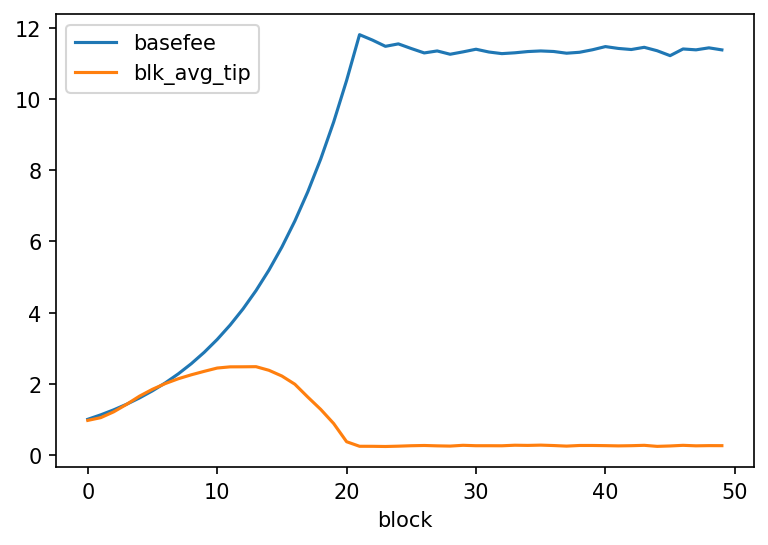

In [18]:
df_fixed.plot("block", ["basefee", "blk_avg_tip"])

In the chart above, we note that, this time, the basefee settled at a level lower than in the previous simulation. This could be a clue that the user strategy we have defined, with fixed escalator lengths, achieves lower efficiency: this is because a high basefee indicates the presence of high-value users in the system (if there were none, the basefee would settle lower).

Let's repeat the steps we've done in the first simulation to understand our results.

In [19]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_fixed_df = user_pool_fixed.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_fixed_df = chain_fixed.export()

# Join the two to associate transactions with their senders
user_txs_fixed_df = chain_fixed_df.join(user_pool_fixed_df.set_index("sender"), on="sender")

# We'll only look at the first 16 blocks
first_blocks = user_txs_fixed_df[user_txs_fixed_df.block_height <= 15].copy()
first_blocks["wakeup_block"] = first_blocks["wakeup_block"].astype("category")

Once again, we plot the value and costs of included users across the first 16 blocks.

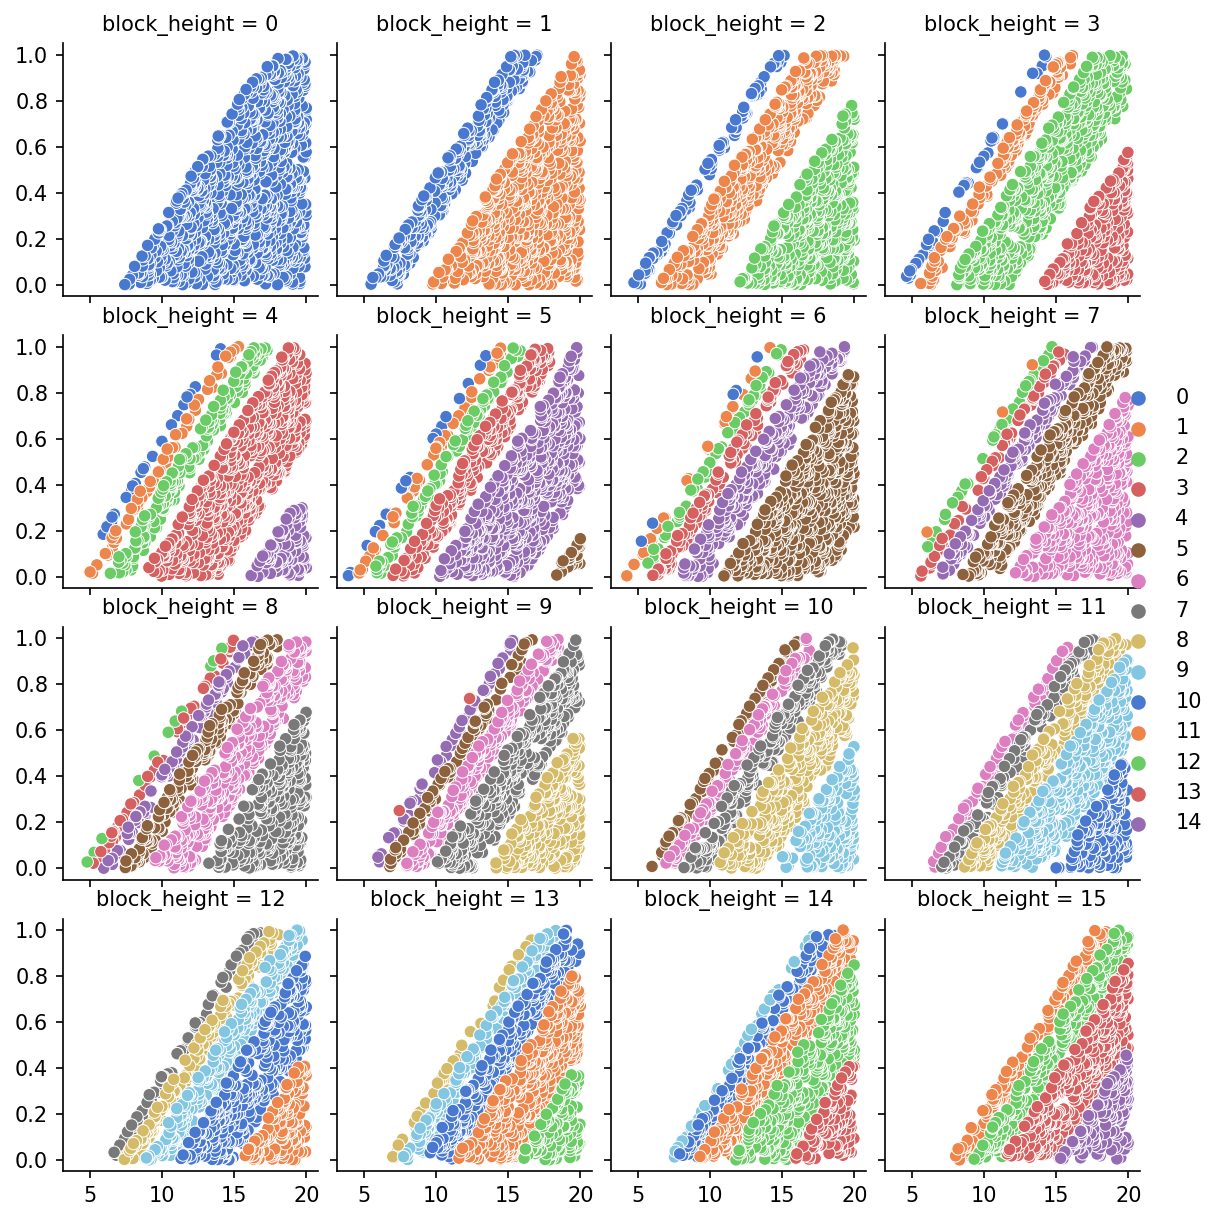

In [20]:
g = sns.FacetGrid(data=first_blocks, col="block_height", col_wrap = 4)
g.map_dataframe(sns.scatterplot, x="value", y="cost_per_unit", hue="wakeup_block", palette="muted")
g.add_legend()
g.fig.set_figwidth(8)
g.fig.set_figheight(8)

There are some interesting regularities!

1. While we previously had early users included in late blocks (e.g., users from the first wave included in block 15), now users must either be included within 10 blocks or drop out. Not surprising since we set the escalator length to the fixed duration of five blocks, and adjusted the slope from there.
2. Once again, users are "stratified" in blocks. Low-valued users with high costs for waiting from earlier waves get in earlier than low-valued users with high costs for waiting from the current wave.
3. The oblique stratas are due to the condition we spelt out earlier, requiring that users with $v - c \ell < 0$ do not join the queue, since these would not be guaranteed a positive payoff in any scenario.
4. We observe again the shift towards the right, with low-valued users priced out as the basefee increases.

What of the social welfare now?

In [21]:
user_txs_fixed_df["total_sw"] = user_txs_fixed_df.apply(
    lambda row: row.value - (row.block_height - row.wakeup_block) * row.cost_per_unit - row.basefee,
    axis = 1
)
sw_fixed = sum(user_txs_fixed_df["total_sw"])
sw_fixed

285514.69211695745

Recall that the social welfare with _hurry_ strategies was given by:


In [22]:
sw_hurry

216733.6431947058

Seems that our alternative, _fixed_, has a higher social welfare than the _hurry_ strategies we explored previously. What gives?

Although both social welfare measures are in the same "unit" (payoffs minus costs, so ethers), we are still not fairly comparing the two situations. In a sense, the "fixed length" escalator users are not at equilibrium: a high value user ought to bid higher to get in quickly, and not be discouraged by the possibility of not being included after the (arbitrary) escalator duration.

This is not to say that all users implementing the _hurry_ strategy is an equilibrium either. Yet the basefee settles at a noticeably higher level, as if it were better able to match the existing demand to the supply. Since the social welfare as we defined it is lower when the basefee is higher, it is worse in the _hurry_ scenario than in the _fixed_ one.

**The takeaway is that social welfare comparisons are not that informative when comparing two non-equilibrium profiles.** As an alternative, we could adopt the following metric: look only at the profile of users who are included and compute the value they obtained -- their initial value minus waiting costs. We call this _user efficiency_.

## User efficiency and optimality of _hurry_ and _fixed_

User efficiency is more helpful to compare the efficiency of the mechanism (and strategies) **relative to some optimum measure**. But defining the optimum is another issue. For instance, here is an unreasonable optimum: everyone is included! Since this is not a feasible scenario, we restrict our optimum to meaningful cases, where the constraints of the chain apply.

With each new wave of users, we have a new distribution of values and costs. We instantiate here a "greedy" optimum definition. At each wave, **we include in a block as many _valid_ users as we can, with users who receive the highest current value from inclusion (value minus waiting costs) first**. The dynamics are the same as before, except we replace our strategic miner optimising for their tips, with a benevolent dictator whose sole objective is to maximise the total current value of users in a block.

We subclass our `TxPool` object to implement this benevolent miner behaviour.

In [23]:
class GreedyTxPool(TxPoolFloatingEsc):
    
    def select_transactions(self, env, **kwargs):
        user_pool = kwargs["user_pool"]
        basefee = env["basefee"]
        
        # Miner side
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])
        
        # Get all users with transactions in the transaction pool
        users_in_pool = [user_pool.get_user(tx.sender) for tx in self.txs.values()]
        
        # Keep only users who would transact now, given their current value
        valid_users = [user for user in users_in_pool if user.current_value(env) >= basefee]
    
        # Users are sorted with higher current value users included first
        sorted_valid_demand = sorted(
            valid_users,
            key = lambda user: -user.current_value(env)
        )
        selected_users = [user.pub_key for user in sorted_valid_demand[0:max_tx_in_block]]
        selected_txs = [tx for tx in self.txs.values() if tx.sender in selected_users]

        return selected_txs
    
    # We'll keep users around and let the pool select the ones it prefers
    # among users with high enough current value
    def remove_invalid_txs(self, env):
        pass

We'll also modify our users to have them transact always. The pool will decide who gets in or not.

In [24]:
class AlwaysOnUser(UserHurryEsc):
    
    def create_transaction(self, env):
        
        # The tx_params don't really matter, since
        # greedy transaction pools disregard them to decide who is included
        tx_params = self.decide_parameters(env)
        
        tx = TxFloatingEsc(
            sender = self.pub_key,
            tx_params = tx_params,
            rng = self.rng,
        )

        return tx

Let's rerun the simulation loop, using our new `GreedyTxPool` and `AlwaysOnUser`s.

In [25]:
rng = np.random.default_rng(42)
demand_scenario = [users_per_round for i in range(blocks)]

shares_scenario = [{
    AlwaysOnUser: 1,
} for i in range(blocks)]

(df_greedy, user_pool_greedy, chain_greedy) = simulate(
    demand_scenario, shares_scenario,
    TxPool = GreedyTxPool,
    rng=rng,
)

In [26]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_greedy_df = user_pool_greedy.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_greedy_df = chain_greedy.export()

# Join the two to associate transactions with their senders
user_txs_greedy_df = chain_greedy_df.join(user_pool_greedy_df.set_index("sender"), on="sender")

We now obtain the total user efficiency, the sum of all [value minus waiting costs] of users. We'll also check the average level of basefee after it stabilises.

In [27]:
def get_user_efficiency(df):
    return sum(
        df.apply(
            lambda row: row.value - (row.block_height - row.wakeup_block) * row.cost_per_unit,
            axis = 1
        )
    )

def get_average_basefee(df):
    return np.mean(df[df.block >= 30]["basefee"])

pd.DataFrame({
    "simulation": ["greedy", "hurry", "fixed"],
    "user_efficiency": [get_user_efficiency(df) for df in [user_txs_greedy_df, user_txs_hurry_df, user_txs_fixed_df]],
    "basefee": [get_average_basefee(df) for df in [df_greedy, df_hurry, df_fixed]],
})

,simulation,user_efficiency,basefee
0,greedy,592807.735952,16.187640
1,hurry,527935.126412,15.721727
2,fixed,523601.811824,11.366102


Both user efficiencies of _hurry_ and _fixed_ simulations are below our greedy optimum <span class="reference footnote" refid="optimum">[6]</span>. They are not far from each other, but user efficiency of _hurry_ is higher than _fixed_. This sits better with our intuition that a higher basefee entails the "correct" users are matched, so the user value realised with everyone playing _hurry_ should be greater than the value under _fixed_.

To expand on this, **_hurry_ puts users with higher waiting costs in front of line**, at the expense of potentially high value users who have low waiting costs. Meanwhile, **_fixed_ gives precendence to high value users with low waiting costs**, who will have a higher escalator slope. The downside is that high value users with high waiting costs do not join, since they expect a negative payoff. Losing this part of the population means **the basefee can afford to be lower than it is under the _hurry_ strategy**.

## Conclusion

In the best of all worlds, the same users who are included in the idealised _greedy_ scenario are actually included on-chain. Is this possible? It could be if we find a user strategy which induces an **equilibrium**, a situation where no user would prefer to play a different strategy, and if in turn this equilibrium induces the optimal allocation.

Yet the optimal allocation is not always an equilibrium (think about [the Prisoner's dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma)). Is this the case here? What is the best strategy for users in the floating escalator paradigm? And under this strategy, does the floating escalator achieve higher user efficiency than plain vanilla 1559 does?

## (Bonus) A random benchmark

We could check the efficiency of a "bad" transaction pool behaviour to get a "lower bound" benchmark. A very bad transaction pool behaviour may be to include low value users first, the opposite of the optimum pool, or include no one at all, in which case the total value is zero. We don't think these are very informative. A reasonably bad transaction pool behaviour would **sample at random valid transactions in its pool and include them in the next block**.

In [28]:
class RandomTxPool(TxPoolFloatingEsc):
    def select_transactions(self, env, **kwargs):
        rng = kwargs["rng"]
        user_pool = kwargs["user_pool"]
        basefee = env["basefee"]
        
        # Miner side
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])
        
        # Get all users with transactions in the transaction pool
        users_in_pool = [user_pool.get_user(tx.sender) for tx in self.txs.values()]
        
        # Keep only users who would transact now, given their current value
        valid_users = [user.pub_key for user in users_in_pool if user.current_value(env) >= basefee]
        
        # Find their transactions in the pool
        valid_txs = [tx for tx in self.txs.values() if tx.sender in valid_users]
        
        # Shuffle them and pick at random to fill the block
        rng.shuffle(valid_txs)
        selected_txs = valid_txs[0:max_tx_in_block]

        return selected_txs
    
    # We'll keep users around and let the pool select the ones it prefers
    # among users with high enough current value
    def remove_invalid_txs(self, env):
        pass

In [29]:
rng = np.random.default_rng(42)
demand_scenario = [users_per_round for i in range(blocks)]

shares_scenario = [{
    AlwaysOnUser: 1,
} for i in range(blocks)]

(df_random, user_pool_random, chain_random) = simulate(
    demand_scenario, shares_scenario,
    TxPool = RandomTxPool,
    rng=rng,
)

Let's look at the basefee and average tip in the block.

<AxesSubplot:xlabel='block'>

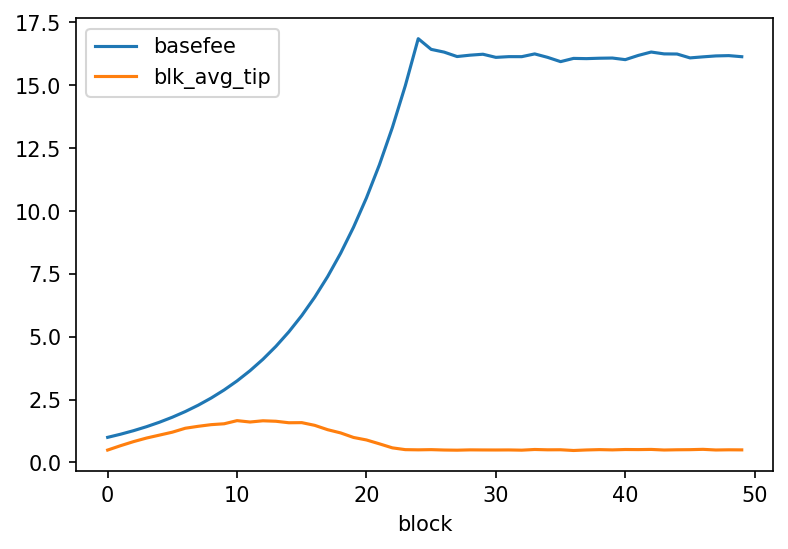

In [30]:
df_random.plot("block", ["basefee", "blk_avg_tip"])

How much value do users achieve?

In [31]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_random_df = user_pool_random.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_random_df = chain_random.export()

# Join the two to associate transactions with their senders
user_txs_random_df = chain_random_df.join(user_pool_random_df.set_index("sender"), on="sender")

get_user_efficiency(user_txs_random_df)

509149.6237617843

This is lower than anything we've seen so far, confirming that the random inclusion policy is not a very good one. Let's compare all four environments.

In [32]:
pd.DataFrame({
    "simulation": ["greedy", "hurry", "fixed", "random"],
    "user_efficiency": [get_user_efficiency(df) for df in [user_txs_greedy_df, user_txs_hurry_df, user_txs_fixed_df, user_txs_random_df]],
    "basefee": [get_average_basefee(df) for df in [df_greedy, df_hurry, df_fixed, df_random]],
})

,simulation,user_efficiency,basefee
0,greedy,592807.735952,16.187640
1,hurry,527935.126412,15.721727
2,fixed,523601.811824,11.366102
3,random,509149.623762,16.136528
